# Does parental age affect sex ratio?

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [25]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf

The following cell downloads data from https://www.cdc.gov/nchs/data_access/vitalstatsonline.htm

[The codebook is here](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/DVS/natality/UserGuide2018-508.pdf)

In [39]:
import os

filename18 = 'Nat2018us.zip'
if not os.path.exists(filename18):
    !wget ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/DVS/natality/Nat2018us.zip

We can open the file in the Zip archive without unpacking.

In [41]:
from zipfile import ZipFile

zf = ZipFile(filename18)
filenames = zf.namelist()
print(filenames)
fp = zf.open(filenames[0])

['Nat2018PublicUS.c20190509.r20190717.txt']


Read the file and get the variables we are interested in.

In [14]:
names = ['mager',       # mother's age
         'fagecomb',    # father's age
         'lbo_rec',     # live birth order (recode)
         'sex']         # sex of baby

colspecs = [(75-1, 76),
           (147-1, 148),
           (179-1, 179),
           (475-1, 475)]

df = pd.read_fwf(fp,
                 colspecs=colspecs,
                 names=names,
                 nrows=None)

df.shape

(3801534, 4)

Here are the first few rows.

In [15]:
df.head()

,mager,fagecomb,lbo_rec,sex
0,10,5,NaN,0
1,35,35,3.0,F
2,28,31,2.0,M
3,23,26,3.0,F
4,37,35,2.0,M


Here are the values of `sex`

In [16]:
df['sex'].value_counts(dropna=False)

M    1943272
F    1858261
0          1
Name: sex, dtype: int64

And the distribution of mother's age.

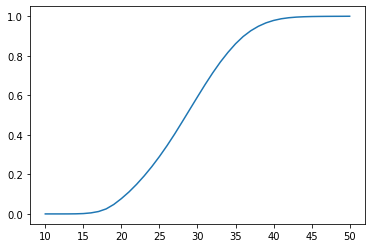

In [28]:
Cdf.from_seq(df['mager']).plot()

In [18]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts().sort_index()

Here are the highest values of father's age.

In [19]:
values(df['fagecomb']).tail(10)

81         5
82         3
83         8
84         3
85         1
88         3
91         1
95         1
98         1
99    441149
Name: fagecomb, dtype: int64

`99` is the code for missing data.

In [29]:
df['fagecomb'].replace(99, np.nan, inplace=True)

Some of the other values are higher than expected.  I'm going to set values higher than 80 to NaN.  But feel free to skip this step.  It doesn't make any difference.

In [30]:
old = (df['fagecomb'] >= 80)
df.loc[old, 'fagecomb'] = np.nan

Here's the distribution of father's age.

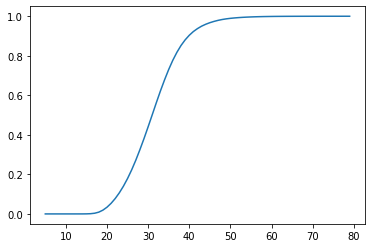

In [31]:
Cdf.from_seq(df['fagecomb']).plot()

For logistic regression, StatsModels needs the dependent variable to be an integer-encoded Boolean.

In [32]:
df['y'] = (df['sex']=='M').astype(int)

I'll select rows with valid data for all three variables.

In [33]:
valid = df.dropna(subset=['mager', 'fagecomb', 'sex'])
valid.shape

(3360354, 5)

And run the model.

In [34]:
import statsmodels.formula.api as smf

formula = 'y ~ mager + fagecomb'
results = smf.logit(formula, data=valid).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.692879
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:              3360354
Model:                          Logit   Df Residuals:                  3360351
Method:                           MLE   Df Model:                            2
Date:                Thu, 06 Aug 2020   Pseudo R-squ.:               5.718e-07
Time:                        15:48:25   Log-Likelihood:            -2.3283e+06
converged:                       True   LL-Null:                   -2.3283e+06
Covariance Type:            nonrobust   LLR p-value:                    0.2641
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0544      0.006      9.182      0.000       0.043       0.066
mager       1.801e-05      0.000      0.063      0.950      -0.001       0.001
fagecomb      -0.0003      0.000     -1.148      0.251      -0.001       0.000
==============================================================================
"""

It sure doesn't look like parental age has any effect on sex ratio.